<a href="https://colab.research.google.com/github/YahiaAbdeldjalilBenyahia/graph-coloring/blob/main/exact/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Used Gemini 2.0 Flash for generating common huristics, also for text to matrix conversion*
---



In [ ]:
import numpy as np
import random
import time

### 1. Reading graph and converting to adjacent matrix

In [ ]:
import requests

url = "https://cedric.cnam.fr/~porumbed/graphs/r125.5.col"
response = requests.get(url)
text = response.text
# Split the text into lines
lines = text.split('\n')

# Split the text into lines
lines = text.split('\n')

# Find the line that starts with 'p' which contains the number of vertices and edges
num_vertices = -1
for line in lines:
    if line.startswith('p'):
        parts = line.split()
        num_vertices = int(parts[2])
        break

print(f"Number of vertices: {num_vertices}")
# Initialize an adjacency matrix with zeros
adj_matrix = np.zeros((num_vertices, num_vertices), dtype=int)

# Iterate through each line in the text
for line in lines:
    if line.startswith('e'):
        parts = line.split()
        a = int(parts[1]) - 1  # Convert to zero-based index
        b = int(parts[2]) - 1  # Convert to zero-based index
        adj_matrix[a][b] = 1
        adj_matrix[b][a] = 1  # Since the graph is undirected

print(adj_matrix)

Number of vertices: 125
[[0 1 1 ... 0 0 0]
 [1 0 1 ... 0 0 1]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 0 0]
 [0 1 0 ... 0 0 0]]


In [ ]:
N = num_vertices # Number of nodes in adjacency matrix
UNDEFINED_COLOR = 999999 # this is used for indicating that the node is not colored

In [ ]:
# sorting nodes high to low based on node degree
# node_degree = {(node_index, corresponding degree)}
node_degrees = sorted([(i, np.sum(adj_matrix[i])) for i in range(N)], key=lambda x: -x[1]) # (node, degree) sorted desc by degree

### Defining node of search tree

In [ ]:
class Node:
    def __init__(self, colors, borne_inf):
        self.colors = colors
        self.borne_inf = np.nan

#### Copying an array

In [ ]:
def copy(ar):
    cp = []
    for i in range(len(ar)):
        cp.append(ar[i])
    return cp

### Using construction method

In [ ]:
class BranchAndBound:
    def __init__(self, adj_matrix, N, UNDEFINED_COLOR):
        self.adj_matrix = adj_matrix
        self.N = N
        self.UNDEFINED_COLOR = UNDEFINED_COLOR
        self.best_solution = None
        self.best_colors = None

    def dsatur(self, colors):
        """
        DSATUR Graph Coloring Algorithm.

        Args:
            adj_matrix: Adjacency matrix of the undirected graph.
            N: Number of nodes in the graph.
            UNDEFINED_COLOR: Value representing an unassigned color.
            colors: A list of integers representing the color assigned to each node.
               Initialized with UNDEFINED_COLOR.

        Returns:
         A list of integers representing the color assigned to each node.
        """

        saturation_degrees = np.zeros(N, dtype=int)  # Saturation degree of each node
        available_colors = [set() for _ in range(N)]  # Available colors for each node

        # Initialize saturation degrees and available colors
        for i in range(N):
            available_colors[i] = set(range(1, N + 1))  # Initially all colors are available

        uncolored_nodes = list(range(N))

        while uncolored_nodes:
            # Find the node with the maximum saturation degree
            max_sat_node = -1
            max_sat_degree = -1
            for node in uncolored_nodes:
                if saturation_degrees[node] > max_sat_degree:
                    max_sat_degree = saturation_degrees[node]
                    max_sat_node = node
                elif saturation_degrees[node] == max_sat_degree and len(available_colors[node]) < len(available_colors[max_sat_node]):
                    max_sat_node = node

            if max_sat_node == -1:
                # All remaining nodes have saturation degree 0, pick one with smallest available colors
                min_available_colors = float('inf')
                for node in uncolored_nodes:
                    if len(available_colors[node]) < min_available_colors:
                        min_available_colors = len(available_colors[node])
                        max_sat_node = node

            # Find the smallest available color for the selected node
            chosen_color = min(available_colors[max_sat_node])

            colors[max_sat_node] = chosen_color
            uncolored_nodes.remove(max_sat_node)

            # Update saturation degrees and available colors of neighbors
            for neighbor in range(N):
                if adj_matrix[max_sat_node][neighbor] == 1:
                    if colors[neighbor] == UNDEFINED_COLOR:
                        available_colors[neighbor].discard(chosen_color)
                        if chosen_color not in [colors[n] for n in range(N) if adj_matrix[neighbor][n] == 1 and colors[n] != UNDEFINED_COLOR]:
                            saturation_degrees[neighbor] += 1

        return len(set(colors))



    def welsh_powell(self, colors):
        """
        Welsh-Powell Graph Coloring Algorithm.

        Args:
            adj_matrix: Adjacency matrix of the undirected graph.
            N: Number of nodes in the graph.
            UNDEFINED_COLOR: Value representing an unassigned color.
            colors: A list of integers representing the color assigned to each node.
               Initialized with UNDEFINED_COLOR.

        Returns:
            A list of integers representing the color assigned to each node.
        """

        # Sort nodes by degree in descending order
        degrees = np.sum(adj_matrix, axis=1)
        sorted_nodes = sorted(range(N), key=lambda x: degrees[x], reverse=True)

        available_colors = set(range(1, N + 1))

        for node in sorted_nodes:
            for color in available_colors:
                is_safe = True
                for neighbor in range(N):
                    if adj_matrix[node][neighbor] == 1 and colors[neighbor] == color:
                        is_safe = False
                        break
                if is_safe:
                    colors[node] = color
                    break
        return len(set(colors))

    def greedy_coloring(self, colors):
        """
        Greedy Graph Coloring Algorithm (with pre-colored nodes).

        Args:
            adj_matrix: Adjacency matrix of the undirected graph.
            N: Number of nodes in the graph.
            colors: A list of integers representing the initial color assignment for each node.
               Nodes that are not pre-colored should have a value like 0 (or any value representing "uncolored").

        Returns:
            The number of colors used in the coloring.  The 'colors' list is also modified in place.
        """
        for node in range(N):
            if colors[node] == UNDEFINED_COLOR: # Only color if the node is not pre-colored
                available_colors = set(range(1, N + 1))  # All possible colors initially
                for neighbor in range(N):
                    if adj_matrix[node][neighbor] == 1 and colors[neighbor] != UNDEFINED_COLOR:
                        available_colors.discard(colors[neighbor])  # Remove neighbor's color

                if available_colors:
                    colors[node] = min(available_colors)
                else:
                    max_used_color = max(colors) if any(colors) else 0
                    colors[node] = max_used_color + 1

        return len(set(colors))

    def largest_degree_first(self, colors):
        """
        Largest Degree First (LDF) Graph Coloring Heuristic.

        Args:
            adj_matrix: Adjacency matrix of the undirected graph.
            N: Number of nodes in the graph.

        Returns:
            The number of colors used in the coloring.
        """

        # Calculate degrees and sort nodes by degree (descending)
        degrees = np.sum(adj_matrix, axis=1)
        sorted_nodes = sorted(range(N), key=lambda x: degrees[x], reverse=True)

        for node in sorted_nodes:
            available_colors = set(range(1, N + 1))  # All possible colors initially
            for neighbor in range(N):
                if adj_matrix[node][neighbor] == 1 and colors[neighbor] != UNDEFINED_COLOR:
                    available_colors.discard(colors[neighbor])

            if available_colors:
                colors[node] = min(available_colors)
            else:  # No available colors, assign a new one
                max_used_color = max(colors) if any(colors) else 0
                colors[node] = max_used_color + 1

        return len(set(colors))

    def incidence_degree_ordering(self, colors):
        """
        Incidence Degree Ordering (IDO) Graph Coloring Heuristic.

        Args:
            adj_matrix: Adjacency matrix of the undirected graph.
            N: Number of nodes in the graph.

        Returns:
            The number of colors used in the coloring.
        """
        # Calculate incidence degrees (number of differently colored neighbors)
        incidence_degrees = np.zeros(N, dtype=int)

        for _ in range(N):  # Iterate N times to color all nodes
            # Find the node with the maximum incidence degree among uncolored nodes
            max_incidence_node = -1
            max_incidence_degree = -1
            for node in range(N):
                if colors[node] == UNDEFINED_COLOR and incidence_degrees[node] > max_incidence_degree:
                    max_incidence_degree = incidence_degrees[node]
                    max_incidence_node = node

            if max_incidence_node != -1: # if we found a node to color
                available_colors = set(range(1, N + 1))
                for neighbor in range(N):
                    if adj_matrix[max_incidence_node][neighbor] == 1 and colors[neighbor] != UNDEFINED_COLOR:
                        available_colors.discard(colors[neighbor])

                if available_colors:
                    colors[max_incidence_node] = min(available_colors)
                else:
                    max_used_color = max(colors) if any(colors) else 0
                    colors[max_incidence_node] = max_used_color + 1

                # Update incidence degrees of uncolored neighbors
                for neighbor in range(N):
                    if adj_matrix[max_incidence_node][neighbor] == 1 and colors[neighbor] == UNDEFINED_COLOR:
                        neighbor_colors = set()
                        for nn in range(N):
                            if adj_matrix[neighbor][nn] == 1 and colors[nn] != UNDEFINED_COLOR:
                                neighbor_colors.add(colors[nn])
                        incidence_degrees[neighbor] = len(neighbor_colors)

        return len(set(colors))



    def getBorneinf(self, colors):
        # return min(self.welsh_powell(colors), self.dsatur(colors))
        return self.dsatur(colors)
        # return min(self.dsatur(colors), self.welsh_powell(colors))
    def possibleColoring(self, node_index, color, current_coloring):
        '''
        this return true if it is possible to colorify node_index with color, given that we already have
        colored some nodes of the graph (current_coloring)
        '''
        for j in range(self.N):
            if self.adj_matrix[node_index][j] == 1:
                if current_coloring[j] == color:
                    return False
        return True

    def explore(self, node):
        # if the graph is fully colored (node has no uncolored graph)
        if UNDEFINED_COLOR not in node.colors:
            if len(set(node.colors)) < self.best_solution:
              self.best_solution = len(set(node.colors))
              self.best_colors = node.colors.copy()
            return
        for i in range(self.N):
            if node.colors[i] == self.UNDEFINED_COLOR:
                for color in range(self.N):
                    if self.possibleColoring(i, color, node.colors):
                        possible_child_colors = node.colors.copy()
                        possible_child_colors[i] = color
                        eval_inf = self.getBorneinf(possible_child_colors.copy())
                        if eval_inf > self.best_solution:
                            continue # elagage
                        else:
                            self.best_solution = eval_inf
                            self.best_colors = possible_child_colors.copy()
                        child = Node(possible_child_colors, eval_inf)
                        self.explore(child)

    def explore_iter(self, node):
        stack = [node]
        while stack:
          current = stack.pop()
          # if the graph is fully colored (node has no uncolored graph)
          if UNDEFINED_COLOR not in node.colors:
            if len(set(current.colors)) < self.best_solution:
              self.best_solution = len(set(current.colors))
              self.best_colors = current.colors.copy()
              continue
          for i in range(self.N):
            if current.colors[i] == self.UNDEFINED_COLOR:
                for color in range(self.N):
                    if self.possibleColoring(i, color, current.colors):
                        possible_child_colors = current.colors.copy()
                        possible_child_colors[i] = color
                        eval_inf = self.getBorneinf(possible_child_colors.copy())
                        if eval_inf > self.best_solution:
                            continue # elagage
                        else:
                            self.best_solution = eval_inf
                            self.best_colors = possible_child_colors.copy()
                        child = Node(possible_child_colors, eval_inf)
                        stack.append(child)

    def solve(self):
        colors = np.zeros(self.N, dtype=int) + self.UNDEFINED_COLOR # all nodes are uncolored initially
        colors[0] = 0 # initialize a coloring for node 0
        borne_inf = self.getBorneinf(colors)
        root = Node(colors, borne_inf) # root node
        self.best_solution = borne_inf
        self.best_colors = colors.copy()
        self.explore_iter(root)
        return self.best_solution, self.best_colors

# Initialize the BranchAndBound class and solve the problem
bb = BranchAndBound(adj_matrix, N, UNDEFINED_COLOR)
start_time = time.time()
best_solution, best_colors = bb.solve()
# Record end time
end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Total Execution Time: {execution_time:.2f} seconds")
print(f"Best solution (minimum number of colors): {best_solution}")
print(f"Coloring of nodes: {best_colors}")

Total Execution Time: 0.38 seconds
Best solution (minimum number of colors): 38
Coloring of nodes: [ 1  2  3 20 32  5  6  4 19  4 23 34 11  6  5  3 26  6 18 29 35  7  8  8
  9  5 10 22 11 12 16 15 30  9 13 19  8 13  7 28 14 12 15  3 17 12 15 21
 16 27  9 26 17 20  4 14 14  8  2  4  6 25 12  1 29  3 33 13 18 19 27 19
  2  9 20 21  1 34 31 17 22  7 21 10 27 33 35 28  1  4  2 23 36  2 36 30
 24 25  1 10 26 17  5 18 16 27 24 31 32 28 29  9 37 15 14  7 23 30 22 31
 24 26 10  3 38]


### Some plots

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
def plot_grouped_histograms(dicts, labels, colors=None):
    """
    Plots grouped histograms to compare multiple methods for each graph on a single axis.

    :param dicts: List of dictionaries (each dict is {"string": integer}).
    :param labels: List of labels for each method.
    :param colors: List of colors for each method (optional).
    """
    keys = sorted(set().union(*dicts))  # Get unique sorted keys (graph names)
    num_dicts = len(dicts)
    x = np.arange(len(keys))  # X positions for groups
    width = 0.2  # Width of each bar

    if colors is None:
        colors = ['blue', 'green', 'red']

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (data_dict, label) in enumerate(zip(dicts, labels)):
        values = [data_dict.get(k, 0) for k in keys]  # Get values, default to 0 if missing
        bars = ax.bar(x + (i - (num_dicts - 1) / 2) * width, values, width, label=label, color=colors[i % len(colors)], alpha=0.7)

        # Add value labels above bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom', fontsize=10)

    ax.set_xticks(x)
    ax.set_xticklabels(keys, rotation=90)  # Rotate x-axis labels vertically
    ax.set_xlabel("Graphs")
    ax.set_ylabel("Best K")
    ax.set_title("Comparaison des heuristiques de coloration")
    ax.legend()
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

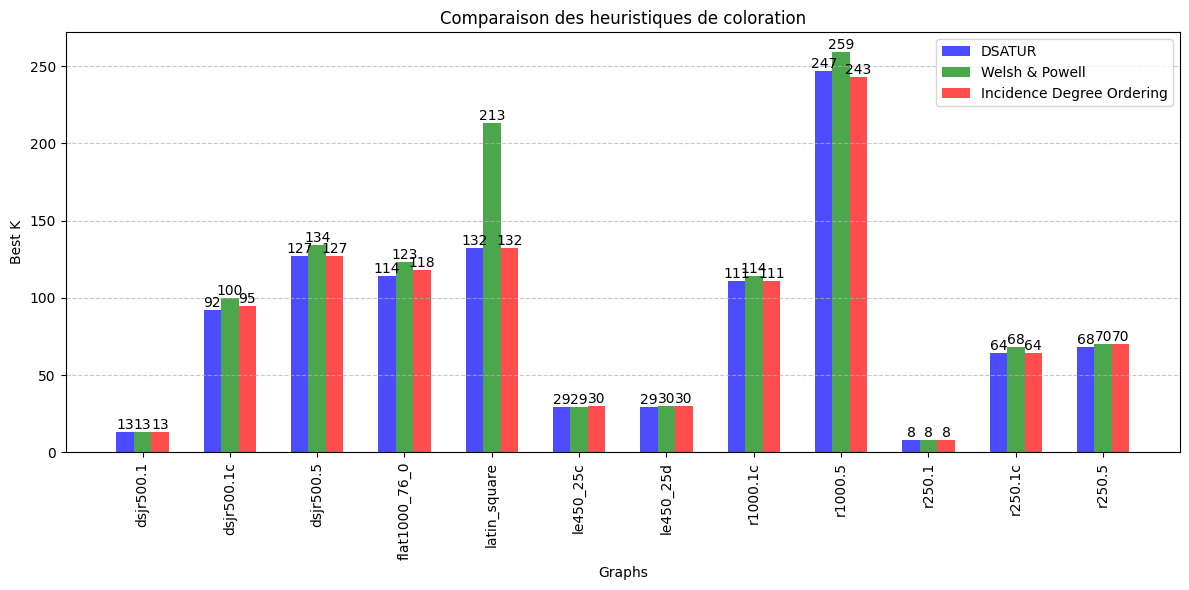

In [ ]:
dsatur = {"r250.5": 68, "r1000.1c": 111, "r1000.5": 247, "dsjr500.1c": 92, "dsjr500.5":127, "le450_25c":29, "le450_25d":29, "flat1000_76_0":114, "latin_square":132, "r250.1":8, "r250.1c":64, "dsjr500.1":13}
welsh = {"r250.5": 70, "r1000.1c": 114, "r1000.5": 259, "dsjr500.1c": 100, "dsjr500.5":134, "le450_25c":29, "le450_25d":30, "flat1000_76_0":123, "latin_square":213, "r250.1":8, "r250.1c":68, "dsjr500.1":13}
incidence_deg_ord = {"r250.5": 70, "r1000.1c": 111, "r1000.5": 243, "dsjr500.1c": 95, "dsjr500.5":127, "le450_25c":30, "le450_25d":30, "flat1000_76_0":118, "latin_square":132, "r250.1":8, "r250.1c":64, "dsjr500.1":13}

plot_grouped_histograms([dsatur, welsh, incidence_deg_ord], labels=["DSATUR", "Welsh & Powell", "Incidence Degree Ordering"])
